<a href="https://colab.research.google.com/github/SimonDelgado/Procesamiento-Digital-Multimedia/blob/main/Actividad5/Actividad_5_DelgadoSimon_202840051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Actividad 5</h2></center>
<center><h3>Audio</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Simón Delgado</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


## 1. Aplique la transformada rápida de fourier a una señal de audio
<p align="justify">
El archivo de audio debe ser formato .WAV, con menos de 30 segundo de duración.


In [161]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import Audio
from scipy.io import wavfile

In [162]:
fs, NY_noise = wavfile.read('/content/320767__wittte__nyc-ambience.wav')

<ipython-input-162-ef7a4f3af11c>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, NY_noise = wavfile.read('/content/320767__wittte__nyc-ambience.wav')


In [163]:
fs

48000

In [164]:
IPython.display.Audio(NY_noise, rate = fs)

In [165]:
samples = len(NY_noise)
t = np.arange(0, samples/fs, 1/fs)

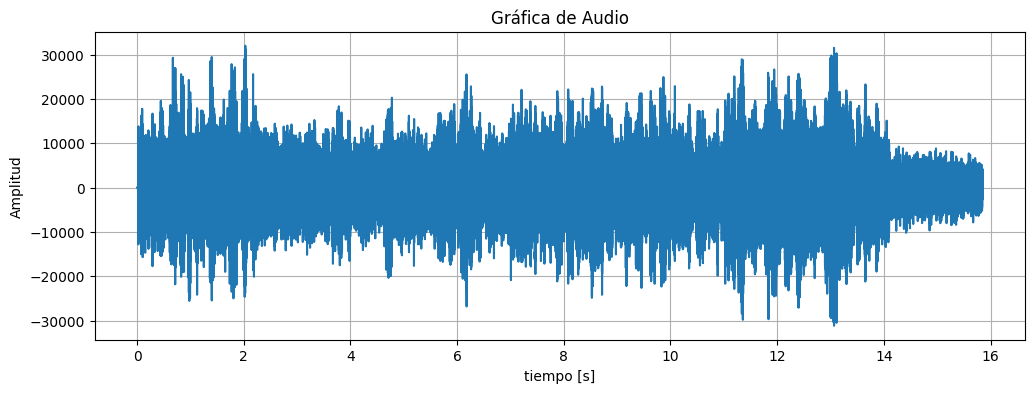

In [166]:
plt.figure(figsize = (12, 4))
plt.plot(t, NY_noise)
plt.title('Gráfica de Audio')
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


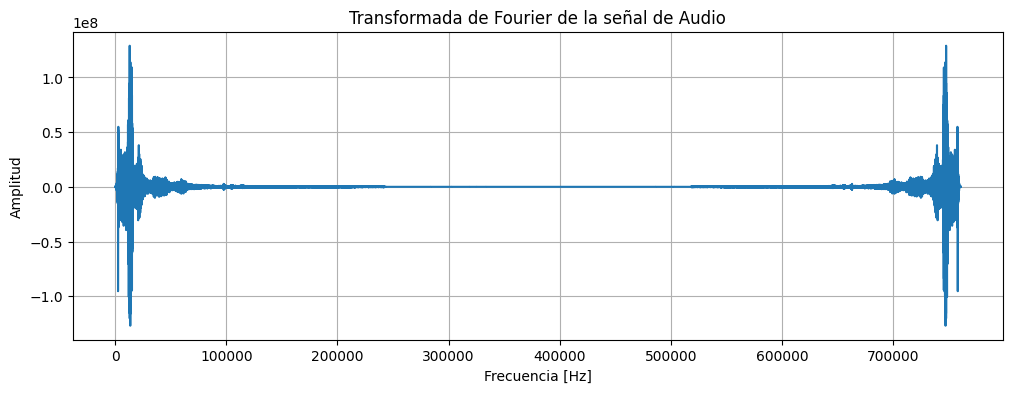

In [167]:
FT_NY = np.fft.fft(NY_noise)
plt.figure(figsize = (12, 4))
plt.plot(FT_NY)
plt.title('Transformada de Fourier de la señal de Audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.grid(True)

## 2. Obtén el espectrograma de tu señal de audio

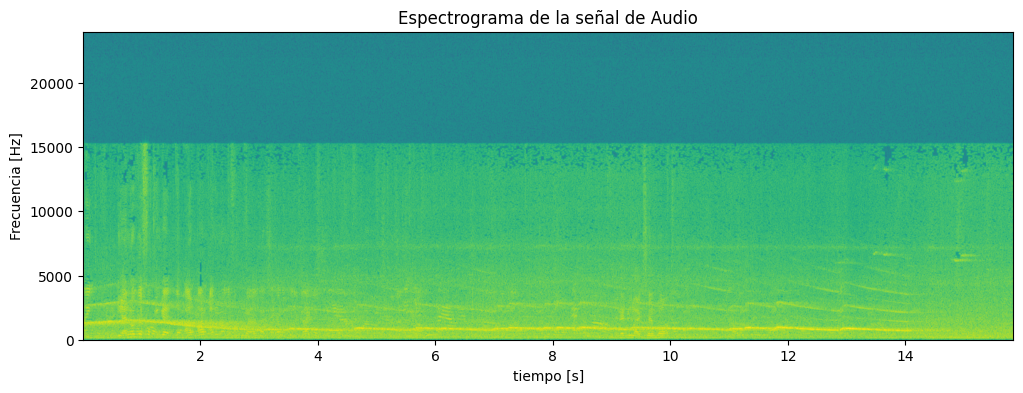

In [168]:
plt.figure(figsize=(12,4))
Pxx, freqs, bins, im = plt.specgram(NY_noise, NFFT=1024, Fs=fs, noverlap=512)
plt.title('Espectrograma de la señal de Audio')
plt.xlabel('tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.grid(False)

## 3. Slicing
Desarrolla un framento de código que te permita tomar una señal de audio y framentarla en N segmentos o slices. Debe asignar la longitud temporal de cada slice y el programa debe indicar el número de slices que quedan. Considera que al final puede quedar un slice de longitud diferente a todos los demas.

En el slicing debes también incluir un gap o overlap a lado y lado de cada uno de los fragmentos. Este overlap debe ser ajustable del número de muestras que constituyen dicho overlap.

In [169]:
! pip3 install pydub

In [170]:
from pydub import AudioSegment
import math

In [171]:
ts = 3 # ventana del slicing
overlap = 0.25 # porcentaje de overlap de 25%

input_audio_file = '/content/320767__wittte__nyc-ambience.wav'
NY = AudioSegment.from_wav(input_audio_file)

batch_size = ts * 1000 # tamaño del slice
duracion = NY.duration_seconds
batches = math.ceil((duracion / ts) * (1 + overlap/2)) # cantidad de slices, comando .ceil aproxima al entero superior

inicio = 0
for i in range(batches):
  slice = NY[inicio : inicio + batch_size + (batch_size * (overlap / 2))] # se corta la señal, donde el límite superior se pasa en la mitad del overlap (12.5%)
  slice.export(f'slice_{i}.wav', format='wav')
  inicio+= batch_size - (batch_size * (overlap / 2)) # se pasa a la siguiente ventana, retrasada en la otra mitad del overlap

In [172]:
Audio(f'slice_{0}.wav', rate=48000)

In [173]:
Audio(f'slice_{1}.wav', rate=48000)

In [174]:
batches # en este caso, desde el 0 hasta el 5

6

In [175]:
Audio(f'slice_{5}.wav', rate=48000) # último slice

## 3.1 Slicing usando Pytorch


In [176]:
import torch

In [177]:
Ns = 6 # número de tensores
NY_noise_tensor = torch.tensor(NY_noise) # se convierte el array en tensor

In [178]:
def guardar_audio(data, fs, nombre_archivo): # Se define la función para guardar señales de audio en archivos WAV
    data = np.clip(data, -32768, 32767) # Convierte todos los datos a un rango de 16 bits
    data = data.astype(np.int16) # Convierte los datos a tipo int16
    wavfile.write(nombre_archivo, fs, data) # se guardan los datos como archivo WAV

num_divisiones = Ns # Número de slices
divisiones = torch.tensor_split(NY_noise_tensor, num_divisiones) # realiza el slicing en Ns cantidad de tensores

for i, division in enumerate(divisiones): # Para pasar los tensores a arrays y luego a archivo WAV
    division_np = division.numpy() # Convierte en array numpy
    guardar_audio(division_np, fs, f'division_{i}.wav') # Convierte y guarda como archivo WAV

In [179]:
Audio(f'division_{0}.wav', rate=48000)

## 4. Filtro Butterworth para una señal de audio.

In [180]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band') # 'butter' arroja los coeficientes del filtro

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order) # coeficientes b y a del filtro
    y = lfilter(b, a, data) # generación del filtro con 'lfilter'
    return y

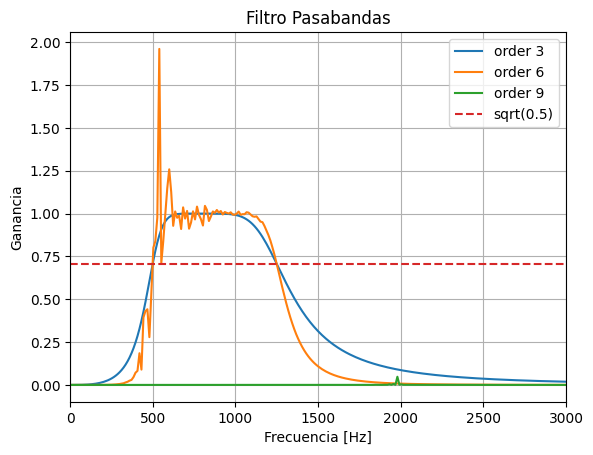

In [181]:
fs = 48000 # 'fs' frecuencia de sampleo del filtro. se elige la misma que en la frecuencia original
lowcut = 500 # corte inferior
highcut = 1250 # corte superior

for order in [3, 6, 9]: # se prueba el filtro para distintos órdenes. Un filtro más grande genera un corte más severo de las frecuencias
  b, a = butter_bandpass(lowcut, highcut, fs, order=order) # obtención de coeficientes según el orden
  w, h = freqz(b, a, fs=fs, worN=2000) # respuesta en frecuencia del filtro
  plt.plot(w, abs(h), label='order %d' % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
           '--', label='sqrt(0.5)') # la ganancia es de 0.707 (sqrt(0.5)) en la frecuencia de corte.
plt.title('Filtro Pasabandas')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Ganancia')
plt.xlim([0, 3000])
plt.grid(True)
plt.legend(loc='best')

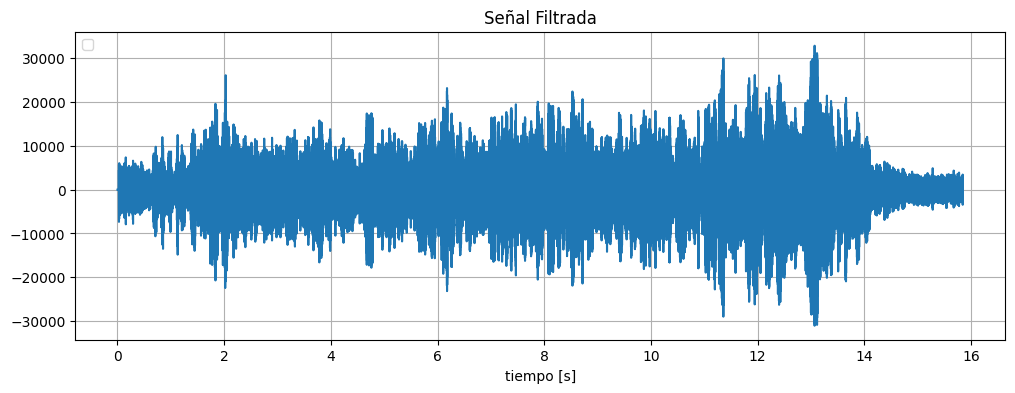

In [182]:
y = butter_bandpass_filter(NY_noise, lowcut, highcut, fs, order=6) #Se aplica el filtro a la señal original 'NY_noise'
plt.figure(figsize=(12,4))
plt.plot(t, y)
plt.title('Señal Filtrada')
plt.xlabel('tiempo [s]')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [183]:
Audio(y, rate=48000) # audio de señal filtrada

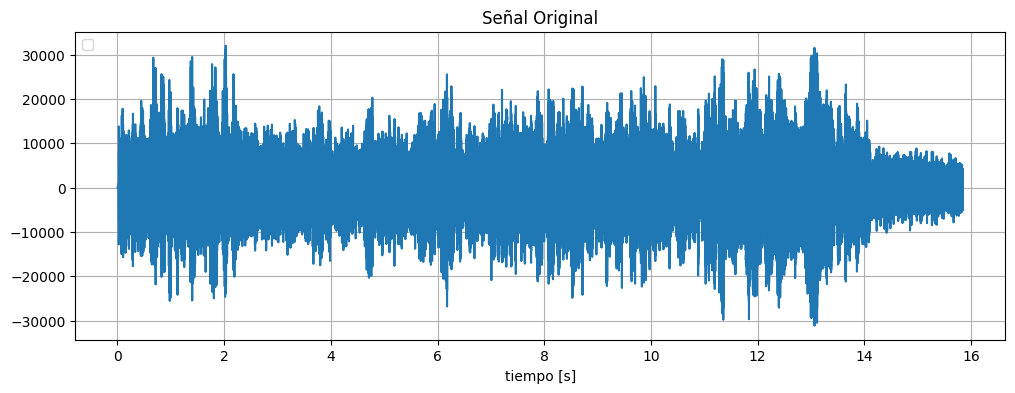

In [184]:
plt.figure(figsize=(12,4))
plt.plot(t, NY_noise) # se compara con la señal original
plt.title('Señal Original')
plt.xlabel('tiempo [s]')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

## 4. Referencias
<p align="justify">
    
[Análisis espectral para audio] https://ccrma.stanford.edu/~jos/mdft/mdft-python.html

[Análisis espectral] https://currents.soest.hawaii.edu/ocn_data_analysis/_static/Spectrum.html
